In [ ]:
# PATHS TO MODEL/DATA
remote_model_path = "/output_gcs_bucket/lema-balerion/training_runs/panos/corroborate/for_manos_showcase/llama8b.fft.fsdp.sky-2025-02-22-17-31-35-032278_llama1b-sft_3"

remote_data_path = "/output_gcs_bucket/lema-balerion/datasets/minicheck/halloumi_synthetic_benchmark_responselevel_withoriginalrequest_test_2089__presplit_claim_subclaim_citation_label_explanation.jsonl"

save_res_file = (
    remote_model_path
    + "/output/"
    + "halloumi_synthetic_benchmark_responselevel_withoriginalrequest_test_2089__presplit_claim_subclaim_citation_label_explanation.jsonl"
)

In [20]:
# COPY MODEL/DATA LOCALLY
destination_dir = "./tmp/model"
!mkdir -p $destination_dir
!cp -r $remote_model_path/* $destination_dir
model_path = destination_dir


destination_dir = "./tmp/data"
!mkdir -p $destination_dir
!cp $remote_data_path $destination_dir
data_path = destination_dir + "/" + remote_data_path.split("/")[-1]

In [21]:
# LOAD MODEL
import transformers

classifier = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)
classifier = classifier.to("cuda")
tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# for name, param in classifier.named_parameters():
#     print(f"{name}: {param.dtype}") # Note that these are all loaded as bf32...

In [27]:
# LOAD INPUT
import pandas as pd

df = pd.read_json(data_path, orient="records", lines=True)
inputs = df["input"].tolist()

In [28]:
# DO INFERENCE
import numpy as np
import torch
from scipy.special import softmax
from tqdm import tqdm

probs = []
predictions = []
with torch.no_grad():
    for i in tqdm(inputs):
        inp = tokenizer(i, return_tensors="pt").to("cuda")
        logits = classifier(**inp).logits.cpu()
        sftmx = softmax(logits[0])
        positive_prob = sftmx[1]
        prediction = np.argmax(sftmx)
        probs.append(positive_prob)
        predictions.append(prediction)

df["classifier pred"] = predictions
df["classifier prob"] = probs

100%|██████████| 2089/2089 [22:37<00:00,  1.54it/s]


In [ ]:
# SAVE INFERENCE RESULTS AT REMOTE

from pathlib import Path

dir_to_save = Path(save_res_file).parent
!mkdir -p $dir_to_save

df.to_json(save_res_file, orient="records", lines=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [42]:
df.head()

,uid,source,context,claims,citations,explanations,all labels,text label,input,label,messages,split,classifier pred,classifier prob
0,halloumi-synthetic-benchmark-v1_8751,halloumi-synthetic-benchmark-v1,Scientists Uncover Clues to Earth's Past in Oc...,The rocks extracted from the ocean floor provi...,"[[s3, s6, s7]]",[The study published in Nature mentions that t...,[supported],SUPPORTED,<context>\nScientists Uncover Clues to Earth's...,0,"[{'role': 'user', 'content': '<|context|><|s1|...",test,0,0.024582
1,halloumi-synthetic-benchmark-v1_8754,halloumi-synthetic-benchmark-v1,Comparative Religion: A Study of Similarities ...,A potential outcome of studying comparative re...,"[[s42], [s39, s42]]",[The document explicitly states that comparati...,"[supported, supported]",SUPPORTED,<context>\nComparative Religion: A Study of Si...,0,"[{'role': 'user', 'content': '<|context|><|s1|...",test,0,0.049294
2,halloumi-synthetic-benchmark-v1_8756,halloumi-synthetic-benchmark-v1,"The Stage of Life\n\nAs the curtains opened, E...",There is no information available in the docum...,"[[None], [s2, s3, s6, s11, s12]]",[The document does not mention saltwater or th...,"[supported, supported]",SUPPORTED,<context>\nThe Stage of Life\n\nAs the curtain...,0,"[{'role': 'user', 'content': '<|context|><|s1|...",test,0,0.411463
3,halloumi-synthetic-benchmark-v1_8765,halloumi-synthetic-benchmark-v1,Nutrition Experts Call for Revised Food Labeli...,There is no information available in the docum...,"[[s1 to s16], [s1, s2, s3, s4, s7, s11, s14, s...",[The document is entirely focused on the topic...,"[supported, supported]",SUPPORTED,<context>\nNutrition Experts Call for Revised ...,0,"[{'role': 'user', 'content': '<|context|><|s1|...",test,0,0.333473
4,halloumi-synthetic-benchmark-v1_8766,halloumi-synthetic-benchmark-v1,The Aroma of Unity\n\nIt was a crisp Sunday mo...,The document does not provide information abou...,"[[s3, s14, s15], [s11, s12, s14, s15]]",[The document highlights the Cultural Food Fes...,"[supported, supported]",SUPPORTED,<context>\nThe Aroma of Unity\n\nIt was a cris...,0,"[{'role': 'user', 'content': '<|context|><|s1|...",test,0,0.309232


In [ ]:
print("BAC:", balanced_accuracy_score(df["label"], df["classifier pred"]))
df["guessed_correctly"] = df["classifier pred"] == df["label"]
print("Accuracy:", df["guessed_correctly"].mean())

BAC: 0.5384086286876443
Accuracy: 0.7257060794638583


In [75]:
df.to_csv("out.csv", index=False)

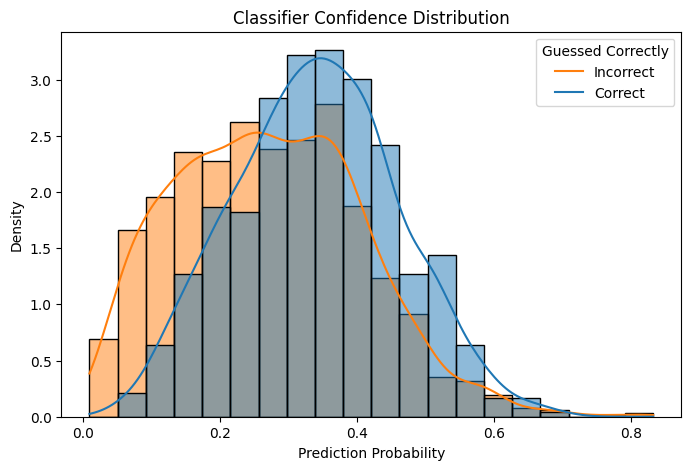

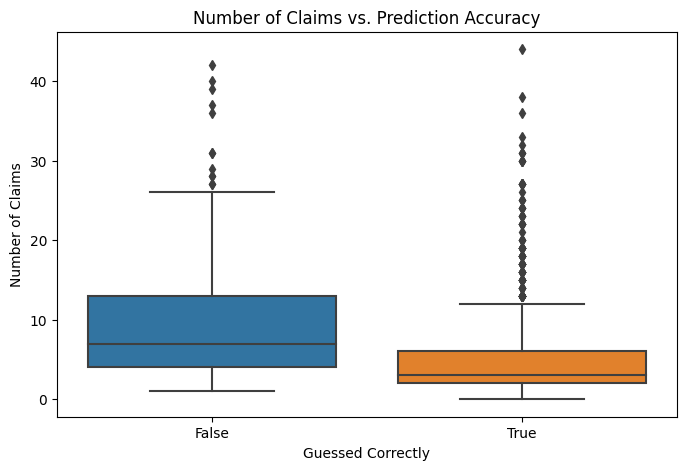

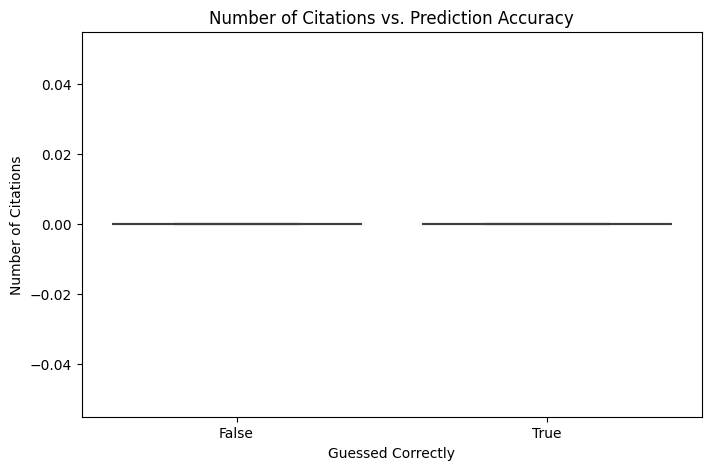

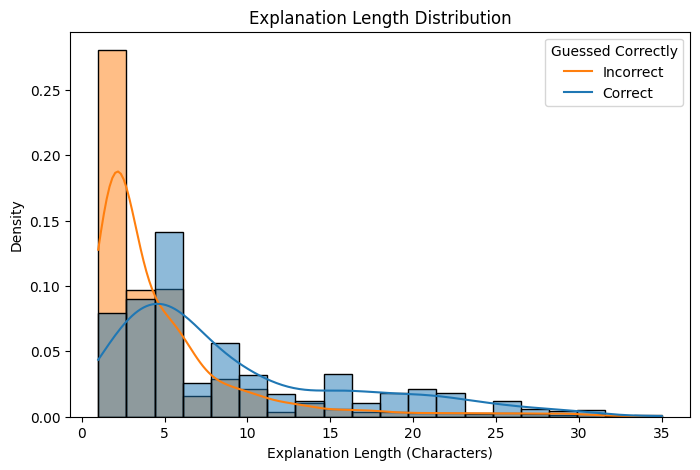

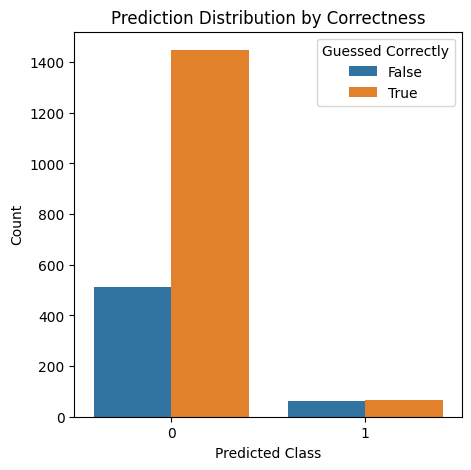

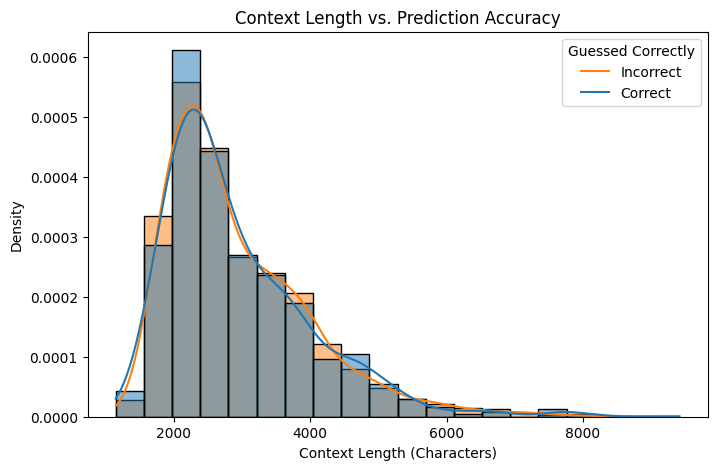

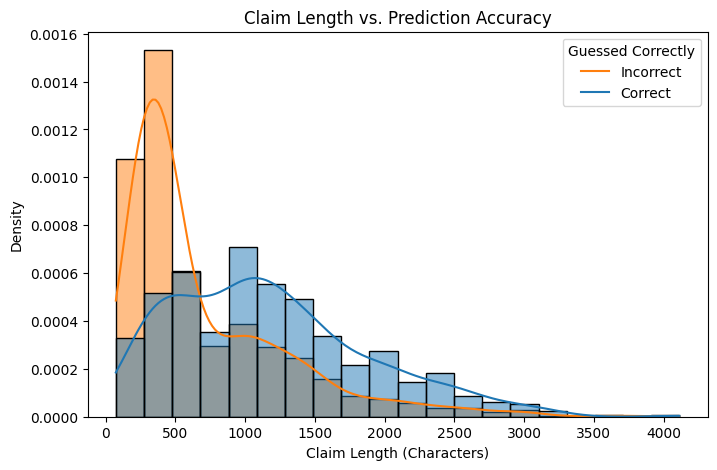

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required columns exist
required_columns = {
    "classifier pred",
    "classifier prob",
    "guessed_correctly",
    "context",
    "claims",
    "citations",
    "explanations",
}
assert required_columns.issubset(df.columns), "Missing required columns in dataset."

# Convert guessed_correctly to boolean if needed
df["guessed_correctly"] = df["guessed_correctly"].astype(bool)

### 1. Classifier Confidence vs. Correctness ###
plt.figure(figsize=(8, 5))
sns.histplot(
    df,
    x="classifier prob",
    hue="guessed_correctly",
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.title("Classifier Confidence Distribution")
plt.xlabel("Prediction Probability")
plt.ylabel("Density")
plt.legend(title="Guessed Correctly", labels=["Incorrect", "Correct"])
plt.show()

### 2. Number of Claims in Input Text ###
df["num_claims"] = df["claims"].fillna("").apply(lambda x: len(str(x).split(".")) - 1)

plt.figure(figsize=(8, 5))
sns.boxplot(x="guessed_correctly", y="num_claims", data=df)
plt.title("Number of Claims vs. Prediction Accuracy")
plt.xlabel("Guessed Correctly")
plt.ylabel("Number of Claims")
plt.show()

### 3. Citation Count Analysis ###
df["num_citations"] = df["citations"].apply(
    lambda x: len(eval(x)) if isinstance(x, str) else 0
)

plt.figure(figsize=(8, 5))
sns.boxplot(x="guessed_correctly", y="num_citations", data=df)
plt.title("Number of Citations vs. Prediction Accuracy")
plt.xlabel("Guessed Correctly")
plt.ylabel("Number of Citations")
plt.show()

### 4. Explanations Length Analysis ###
df["explanation_length"] = df["explanations"].fillna("").apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(
    df,
    x="explanation_length",
    hue="guessed_correctly",
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.title("Explanation Length Distribution")
plt.xlabel("Explanation Length (Characters)")
plt.ylabel("Density")
plt.legend(title="Guessed Correctly", labels=["Incorrect", "Correct"])
plt.show()

### 5. Class Imbalance & Error Analysis ###
plt.figure(figsize=(5, 5))
sns.countplot(x="classifier pred", hue="guessed_correctly", data=df)
plt.title("Prediction Distribution by Correctness")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.legend(title="Guessed Correctly")
plt.show()

### 6. Context Length Analysis ###
df["context_length"] = df["context"].fillna("").apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(
    df,
    x="context_length",
    hue="guessed_correctly",
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.title("Context Length vs. Prediction Accuracy")
plt.xlabel("Context Length (Characters)")
plt.ylabel("Density")
plt.legend(title="Guessed Correctly", labels=["Incorrect", "Correct"])
plt.show()

### 7. Claim Length Analysis ###
df["claim_length"] = df["claims"].fillna("").apply(len)

plt.figure(figsize=(8, 5))
sns.histplot(
    df,
    x="claim_length",
    hue="guessed_correctly",
    bins=20,
    kde=True,
    stat="density",
    common_norm=False,
)
plt.title("Claim Length vs. Prediction Accuracy")
plt.xlabel("Claim Length (Characters)")
plt.ylabel("Density")
plt.legend(title="Guessed Correctly", labels=["Incorrect", "Correct"])
plt.show()

In [94]:
# extract some data for Mike.

# Filter failed predictions
failed_df = df[df["guessed_correctly"] == False]

# Organize columns: Move citations to last, remove 'classifier pred' and 'classifier prob'
columns_to_keep = ["text label", "context", "claims", "explanations"]
failed_df = failed_df[columns_to_keep]

# Sample 100 failed examples, balancing across ground truth labels if possible
num_samples = min(100, len(failed_df))
failed_sampled = failed_df.sample(n=num_samples, random_state=42)

failed_sampled.sort_values("text label", inplace=True)
# Save to CSV
csv_save_path = "failed_predictions.csv"
failed_sampled.to_csv(csv_save_path, index=False)